In [3]:
import numpy as np
import pandas as pd
from __future__ import division
import matplotlib.pyplot as plt
import urllib2,base64
import cPickle as pickle
from collections import Counter
import scipy as sp
import os
import os.path
import cv2
import re
from sklearn import neighbors, datasets,linear_model,preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import scale
from sklearn.feature_extraction import image
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition
from time import time
%matplotlib inline

### Preprocessing (Extraction etc.)

In [4]:
imgs_dir = os.getcwd()+'\\centered'
pattern = re.compile(".leftlight.pgm")
images_list=list()
for filename in os.listdir(imgs_dir):
    if ".leftlight.pgm" in filename or ".rightlight.pgm" in filename or ".glasses.pgm" in filename:
        continue
    image=cv2.imread(imgs_dir+'\\'+filename,0)
    h,w = image.shape
    dimensions=h*w
    image_flatten = image.flatten()
    images_list.append(image_flatten)

images_list=np.array(images_list)

print "Dataset consists of %d faces, each dimension %d" % (len(images_list) , len(images_list[0]))

#images_list_mean=np.mean(images_list, axis=0)
#images_list_std=np.std(images_list, axis=0)
#np.seterr(divide='ignore', invalid='ignore')
#images_list_sta=(images_list-images_list_mean)/images_list_std
#print images_list_sta

Dataset consists of 120 faces, each dimension 45045


In [31]:
n_components=100
estimators = [
    ('PCA',
     decomposition.PCA(n_components=n_components, svd_solver='auto',
                       whiten=True),
     True),

    ('ICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),
]

pcas_dict=dict()
icas_dict=dict()
for name, estimator, center in estimators:
    print("\n\nExtracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = images_list
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_
        
        print 'First {0} principle components given by {1} : {2}'.format(n_components,name, components_)
        if name=='PCA':
            pcas_dict[name]=components_
            variance_explained_ = estimator.explained_variance_ratio_
            pca_transform= estimator.transform(data)
            pcas_dict['variance explained']=variance_explained_
            pcas_dict['transform']=pca_transform
            pcas_dict['estimator']=estimator
            print 'Variance Explained by{0} principle components given by {1} : {2}%'.format(n_components,name, sum(variance_explained_)*100)
        
        else:
            icas_dict[name]=components_
            ica_transform= estimator.transform(data)
            icas_dict['transform']=ica_transform
    



Extracting the top 100 PCA...
done in 0.978s
First 100 principle components given by PCA : [[-0.00051567 -0.00052531 -0.00048011 ..., -0.00437604 -0.0044736
  -0.00415373]
 [ 0.00051949  0.00050999  0.00055161 ..., -0.001      -0.00145184
  -0.00166991]
 [ 0.00018442  0.00019244  0.00015598 ..., -0.00264947 -0.0024346
  -0.0020243 ]
 ..., 
 [ 0.00559676  0.00554676  0.0057168  ..., -0.00537915 -0.00145204
  -0.00026374]
 [-0.0002821  -0.00043505  0.00030122 ..., -0.01055648 -0.0014227
   0.00560515]
 [ 0.0156689   0.01572825  0.01547473 ..., -0.00319113 -0.00192132
  -0.00208375]]
Variance Explained by100 principle components given by PCA : 99.5786597547%


Extracting the top 100 ICA...
done in 0.781s
First 100 principle components given by ICA : [[ -8.39706217e-09  -1.18920264e-08   3.68308545e-09 ...,   3.14555676e-07
    2.54855052e-07   6.96150407e-08]
 [ -2.43242790e-07  -2.45446707e-07  -2.36190611e-07 ...,   1.66531474e-06
    1.61700002e-06   1.60363666e-06]
 [ -4.49193535e-0

In [32]:
image_pcas_df = pd.DataFrame(pca_transform)
image_pcas_df.to_csv('img_pcas.csv', sep=',')
image_pcas_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.000311,1.260478,0.493643,-0.588369,1.692669,0.263092,-0.426103,-0.646894,0.421300,-1.325852,...,-0.337118,0.258876,0.379773,-0.012702,0.148455,-0.014250,-0.487790,0.168093,-0.184869,0.575959
1,0.125564,-0.074151,0.455647,-0.350872,2.817413,0.571867,0.303277,-0.448025,-0.445277,0.608332,...,-1.166273,1.319511,-0.882402,-0.896367,-0.957348,1.579222,1.975843,-1.505779,1.337256,1.710731
2,0.261691,-0.268405,0.311305,0.023559,3.087438,0.695780,0.927445,-0.108928,-0.920838,0.716292,...,0.853964,0.555309,-1.680198,-0.346931,-1.793077,-1.226327,-1.565518,1.544878,-0.647592,-0.931438
3,0.610912,-0.255309,0.316534,-0.206459,3.136406,0.067486,0.455793,-0.001954,-0.030964,0.787788,...,0.170249,-2.593864,1.214674,-1.680056,2.347386,1.002770,1.575093,-1.594465,0.737833,1.749382
4,0.236464,-0.255635,0.184604,-0.254509,2.821835,1.013878,0.907937,0.361583,-0.499372,0.607670,...,0.080199,0.169488,1.436493,0.481759,0.315495,-0.439555,0.870894,-1.301575,-0.111838,0.145198


In [33]:
image_icas_df = pd.DataFrame(ica_transform)
image_icas_df.to_csv('img_icas.csv', sep=',')
image_icas_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.005865,-0.006419,-0.007070,0.005364,-0.006676,0.006962,-0.006589,-0.006782,-0.005513,-0.004925,...,-0.006963,-0.006784,0.004151,0.006731,0.006230,-0.006003,0.001232,-0.008262,-0.007806,0.005754
1,-0.007427,-0.013935,-0.021123,0.015861,-0.006254,-0.009396,-0.006590,-0.010849,0.004844,-0.013603,...,-0.024531,-0.017506,0.011813,0.002348,0.021434,-0.014584,-0.009897,-0.014159,-0.012296,0.032347
2,0.007174,-0.005398,-0.009095,0.003979,-0.006732,0.005618,-0.006730,-0.007423,-0.006445,-0.006123,...,-0.004353,-0.006849,0.008952,0.005993,0.007627,-0.010071,0.006639,-0.002156,-0.007409,0.007309
3,0.000864,-0.007386,-0.013334,0.005329,-0.009032,-0.005028,-0.008661,-0.013023,-0.003571,-0.014304,...,-0.016846,-0.012355,0.011429,0.005684,0.015424,-0.017171,-0.002183,-0.006897,-0.011139,0.017497
4,0.008874,-0.006527,-0.008885,0.007204,-0.006400,0.009883,-0.006735,-0.005603,-0.008074,-0.003869,...,-0.005070,-0.004549,0.005724,0.006345,0.004352,-0.004315,0.007045,-0.006294,-0.004922,0.003721


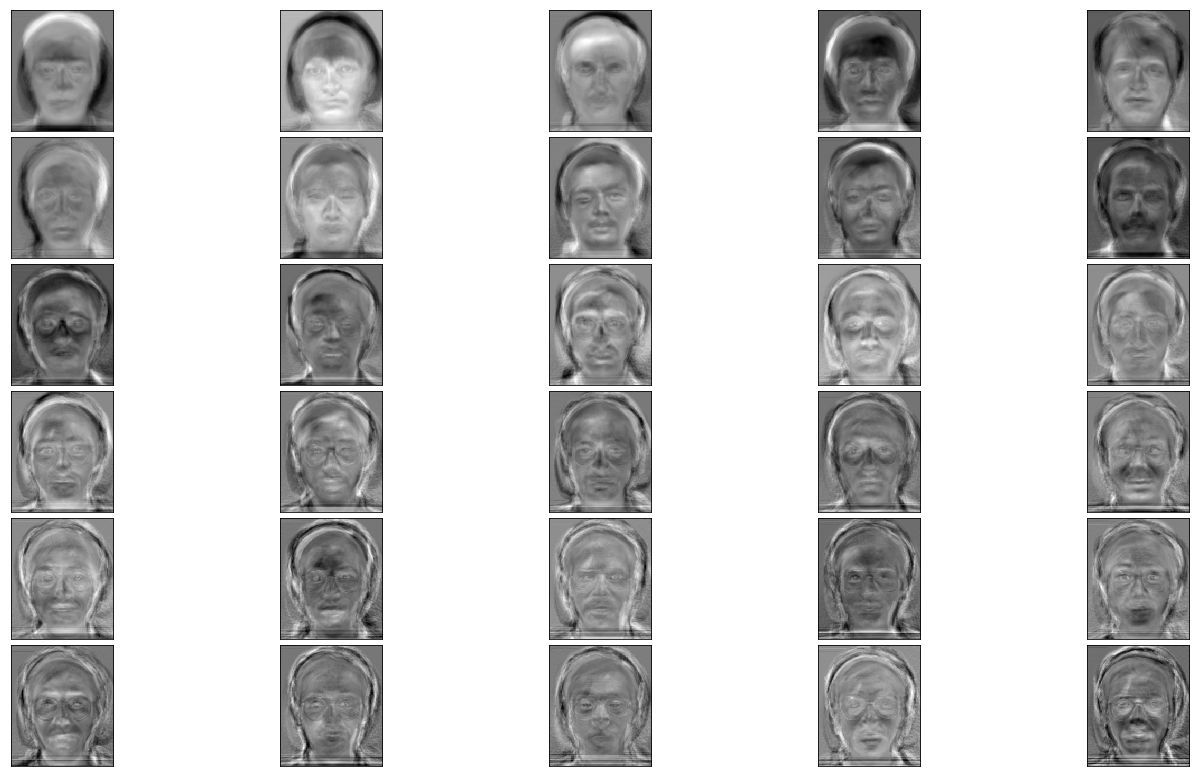

In [14]:
fig = plt.figure() 
fig.set_size_inches(18.5, 10.5, forward=True)
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot the faces, each image is 64 by 64 pixels 
for i in range(30): 
    ax = fig.add_subplot(6, 5, i+1, xticks=[], yticks=[]) 
    ax.imshow(np.reshape(pcas_dict['PCA'][i], (h,w)), cmap=plt.cm.gray, interpolation='nearest') 

First 40 Reconstruct usign first 100 PCs images 



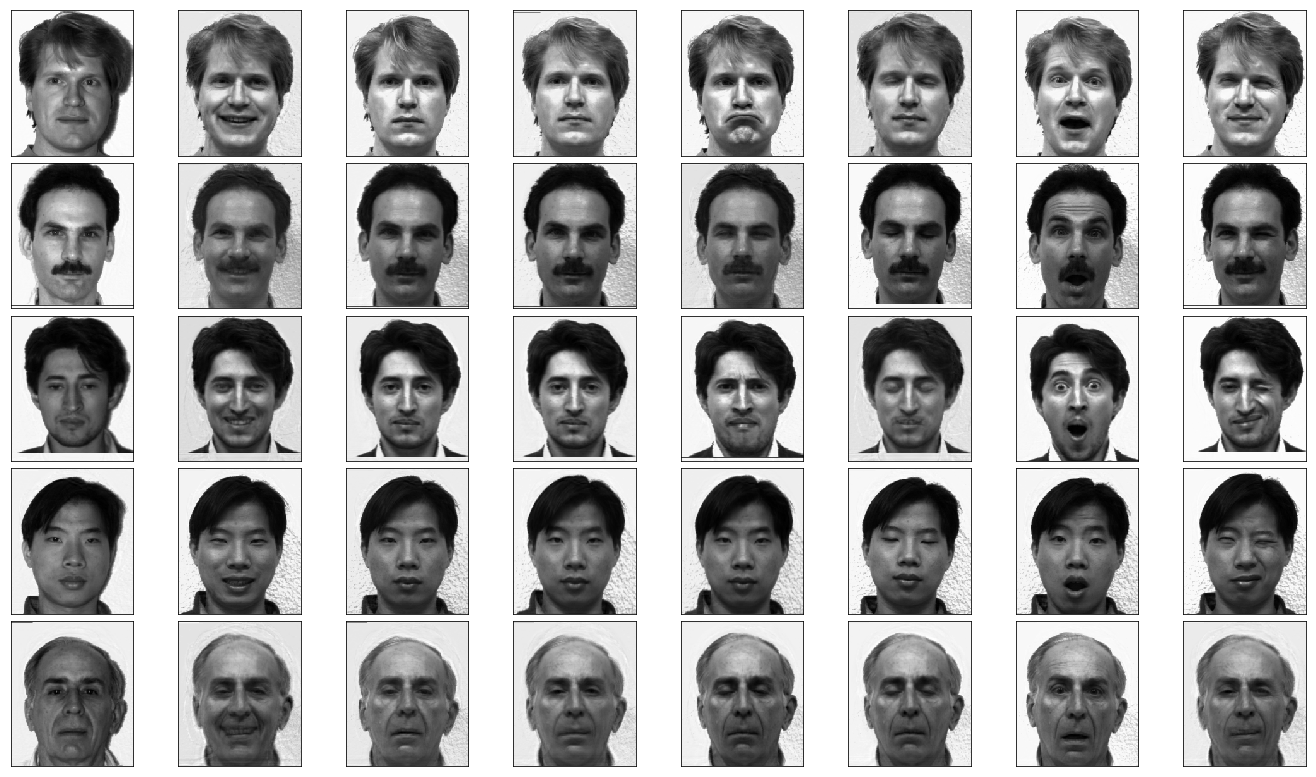

In [17]:
fig_pca = plt.figure(1) 
fig_pca.set_size_inches(18.5, 10.5, forward=True)
fig_pca.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot the faces, each image is 64 by 64 pixels 

print "First 40 Reconstruct usign first 100 PCs images \n"
col=8
row=5
for i in range(40): 
    ax_pca = fig_pca.add_subplot(row, col, i+1, xticks=[], yticks=[]) 
    ax_pca.imshow(np.reshape(pcas_dict['estimator'].inverse_transform(pcas_dict['transform'][i]), (h,w)), cmap=plt.cm.gray, interpolation='nearest') 


First 40 Orginal images  



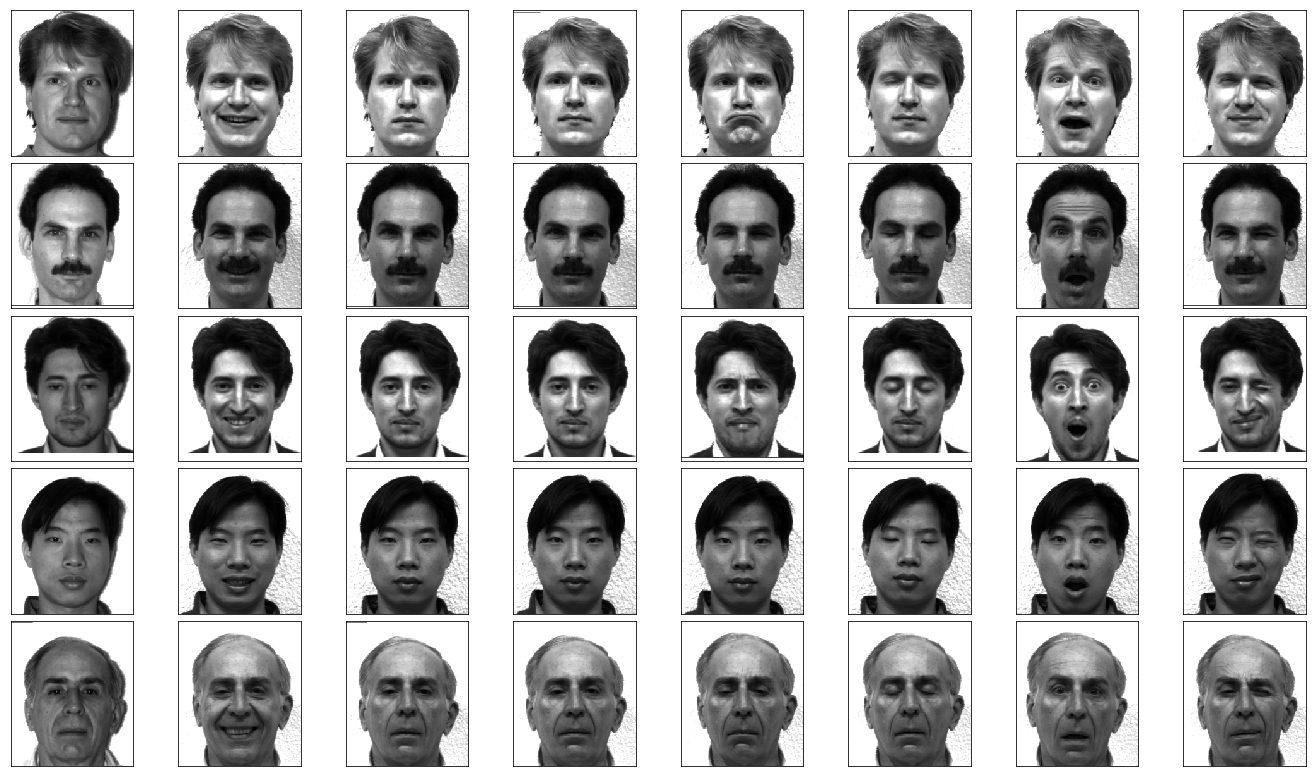

In [10]:
fig_pca = plt.figure(1) 
fig_pca.set_size_inches(18.5, 10.5, forward=True)
fig_pca.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05) 
# plot the faces, each image is 64 by 64 pixels 

print "First 40 Orginal images  \n"
col=8
row=5
for i in range(40): 
    ax_pca = fig_pca.add_subplot(row, col, i+1, xticks=[], yticks=[]) 
    ax_pca.imshow(np.reshape(images_list[i], (h,w)), cmap=plt.cm.gray, interpolation='nearest') 
